In [47]:
# crea graficos interactivos
%matplotlib inline
from astropy.io import fits #para acceder a los archivos FITS
from astropy.table import Table # para crear tablas ordenadas de los datos
import matplotlib.pyplot as plt # para plotear datos
import pandas as pd
import numpy as np
import glob
import math
import os
import random as rnd

# mostrar max columnas necesarias
pd.set_option('display.max_columns', 500) 

In [48]:
from astroquery.mast import Mast
from astroquery.mast import Observations

Definimos las funciones para el manejo de ficheros locales

In [49]:
# Funcion para establecer el nombre de búsqueda en el MAST de un objeto kepler (KOI)
def get_koi_target_name(kepid):
    koi_target_name = "kplr" + format(kepid, '09')
    return koi_target_name

# Comprueba la existencia de ficheros fits para un KOI
def fits_file_exists(koi_target_name):
    fileFind = "./mastDownload/Kepler/" + koi_target_name + "*/*.fits"
    files = glob.glob(fileFind)
    fileExists = len(files) > 0
    return fileExists, files

# Comprueba la existencia de ficheros CSV para un KOI
def csv_file_exists(koi_target_name):
    fileFind = "./mastDownload/Bintables/" + koi_target_name + "*/*.csv"
    files = glob.glob(fileFind)
    fileExists = len(files) > 0
    return fileExists, files

# dado un id de kepler, obtenemos la lista de ficheros csv
def get_csv_from_koi(kepid):
    koi_target_name = get_koi_target_name(kepid)
    csvExists, csv_files = csv_file_exists(koi_target_name)
    return csv_files


En segundo lugar, las funciones que nos ayudarán a la extracción de ficheros FITS y su procesamiento a CSV

In [50]:
# dado el dataframe original descarga los ficheros fits que no estén
def download_fits_files(df_koi):
    for index in range(0, len(df_koi)):

        # Formateamos el id para que valga para hacer query
        koi_target_name = get_koi_target_name(df_koi["kepid"][index])
        fitsExists, fits_files = fits_file_exists(koi_target_name)

        prod = None
        filename = None
        if not fitsExists:
            # Buscamos las observaciones que cadencia corta para el KOI actual
            keplerObs = Observations.query_criteria(
                target_name=koi_target_name,    # nombre del KOI formateado
                obs_id="*_sc_*",                # observaciones de cadencia corta
                obs_collection='Kepler'         # colección Kepler
            )
                
            if len(keplerObs) > 0 :
                # Buscamos los productos asociados a la observación de cadencia corta
                keplerProds = Observations.get_product_list(keplerObs[-1])
                keplerProds = Observations.filter_products(
                    keplerProds,            # productos de la observación
                    extension='_slc.fits',  # archivos fit de cadencia corta
                    mrp_only=False  
                )

                
                if len(keplerProds) > 0 :
                    filename = keplerProds[-1]["dataURI"].split("/")[-1]
                    # hay que repetir esta busqueda para sacar un unico fichero porque
                    # de otra manera da error de conversion
                    prod = Observations.filter_products(
                        keplerProds, 
                        extension=filename,
                        mrp_only=False
                    )

            if not prod is None:
                Observations.download_products(
                    prod, 
                    mrp_only = False, 
                    cache = True
                )
                glob.glob(filePath)

        else:
            filename = files[-1]


        df_koi["filename"][index] = filename

# dada la ruta local del fichero FITS, lo abre y obtenemos los datos que nos serán útiles
# en ocasiones no se puede abrir el fichero por ser de gran tamaño
def get_info_from_fits_file(file):
    try:
        bjdrefi = np.nan
        bjdreff = np.nan
        times = np.nan
        sap_fluxes = np.nan
        pdcsap_fluxes = np.nan

        with fits.open(file, lazy_load_hdus=True) as hdulist: 
            header1 = hdulist[1].header
            binaryext = hdulist[1].data

            # binarytable = Table(binaryext)
            # df_bintable = binarytable.to_pandas()

            # En la cabecera tenemos los datos "BJDREF"
            # es el desplazamiento en el array de tiempo (time)
            bjdrefi = header1['BJDREFI'] 
            bjdreff = header1['BJDREFF']

            # Obtenemos las columnas que nos serán relevantes
            times = binaryext['time'] 
            sap_fluxes = binaryext['SAP_FLUX']
            pdcsap_fluxes = binaryext['PDCSAP_FLUX']
    except:
        print(str(file) + " could not be opened")

    return bjdrefi, bjdreff, times, sap_fluxes, pdcsap_fluxes

# Obtiene ficheros CSV a partir de los ficheros FITS descargados
def proccess_fits_file_to_csv(df_koi, replaceCsv = False):
    df_koi["hasFits"] = 0
    df_koi["hasCsv"] = 0

    for index in df_koi.index: 
        
        koi_target_name = get_koi_target_name(df_koi["kepid"][index])
        fitsExists, fits_files = fits_file_exists(koi_target_name)
        csvExists, csv_files = csv_file_exists(koi_target_name)        

        if (fitsExists and not csvExists) or len(fits_files) != len(csv_files) or replaceCsv:
            # print(index, koi_target_name, fitsExists, csvExists,len(fits_files), len(csv_files), replaceCsv)

            for file in fits_files:
                # fits.info(file)

                # print(koi_target_name, file)
                
                bjdrefi, bjdreff, times, sap_fluxes, pdcsap_fluxes = get_info_from_fits_file(file)

                # Convert the time array to full BJD by adding the offset back in.
                bjds = times + bjdrefi + bjdreff 

                # Almacena todos los datos necesarios en un fichero csv
                data = {
                    "bjdrefi" : bjdrefi,
                    "bjdreff" : bjdreff,
                    "times" : times,
                    "bjds" : bjds,
                    "sap_fluxes" : sap_fluxes,
                    "pdcsap_fluxes" : pdcsap_fluxes
                } 
                df_bintable = pd.DataFrame(data, columns = ["bjdrefi", "bjdreff", "times", "bjds", "sap_fluxes", "pdcsap_fluxes"]) 

                csv_path = file.replace("Kepler", "Bintables").replace(".fits",".csv")
                if not os.path.exists(os.path.dirname(csv_path)):
                    os.makedirs(os.path.dirname(csv_path))
                df_bintable.to_csv(csv_path)

        fitsExists, fits_files = fits_file_exists(koi_target_name)
        csvExists, csv_files = csv_file_exists(koi_target_name)
        df_koi["hasFits"][index] = len(fits_files)
        df_koi["hasCsv"][index] = len(csv_files)

        """    
        if index == 15:
            break
        """
    return df_koi

Establecemos otras funciones que nos ayudarán a mostrar los datos procesados en gráficas

Cargamos el fichero descargado del MAST con todos los KOI 

https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative

Este fichero contiene los identificadores de los KOI así como otra inforamción que nos será relevante como:
- Nombre del elemento para poder identificarlo más fácilmente
- 

In [51]:
newProcess = False
df_koi = pd.read_csv("./mast-info.csv", skiprows=53)

if newProcess:
    download_fits_files(df_koi)
    df_koi_processed = proccess_fits_file_to_csv(df_koi, replaceCsv=False)
else:
    df_koi_processed = pd.read_csv("./mast-info-processed.csv")

df_koi_processed = df_koi_processed.drop("Unnamed: 0", axis=1)
display(df_koi_processed[:15])

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_tce_delivname,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag,hasFits,hasCsv
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,NaN,NaN,93.59,29.45,-16.65,35.8,1.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347,0,0
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,NaN,NaN,9.11,2.87,-1.62,25.8,2.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347,0,0
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,NaN,NaN,39.30,31.04,-10.49,76.3,1.0,q1_q17_dr25_tce,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436,0,0
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,NaN,NaN,891.96,668.95,-230.35,505.6,1.0,q1_q17_dr25_tce,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597,0,0
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,NaN,NaN,926.16,874.33,-314.24,40.9,1.0,q1_q17_dr25_tce,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509,1,1
5,10872983,K00756.01,Kepler-228 d,CONFIRMED,CANDIDATE,1.000,0,0,0,0,11.094321,2.036000e-05,-2.036000e-05,171.201160,0.001410,-0.001410,0.538,0.030,-0.428,4.59450,0.06100,-0.06100,1517.5,24.2,-24.2,3.90,1.27,-0.42,835.0,NaN,NaN,114.81,112.85,-36.70,66.5,1.0,q1_q17_dr25_tce,6046.0,189.0,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714,1,1
6,10872983,K00756.02,Kepler-228 c,CONFIRMED,CANDIDATE,1.000,0,0,0,0,4.134435,1.046000e-05,-1.046000e-05,172.979370,0.001900,-0.001900,0.762,0.139,-0.532,3.14020,0.06730,-0.06730,686.0,18.7,-18.7,2.77,0.90,-0.30,1160.0,NaN,NaN,427.65,420.33,-136.70,40.2,2.0,q1_q17_dr25_tce,6046.0,189.0,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714,1,1
7,10872983,K00756.03,Kepler-228 b,CONFIRMED,CANDIDATE,0.992,0,0,0,0,2.566589,1.781000e-05,-1.781000e-05,179.554370,0.004610,-0.004610,0.755,0.212,-0.523,2.42900,0.16500,-0.16500,226.5,16.8,-16.8,1.59,0.52,-0.17,1360.0,NaN,NaN,807.74,793.91,-258.20,15.0,3.0,q1_q17_dr25_tce,6046.0,189.0,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714,1,1
8,6721123,K00114.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,1,0,7.361790,2.128000e-05,-2.128000e-05,132.250530,0.002530,-0.002530,1.169,7.133,-0.044,5.02200,0.13600,-0.13600,233.7,5.8,-5.8,39.21,6.45,-9.67,1342.0,NaN,NaN,767.22,349.28,-365.49,47.7,1.0,q1_q17_dr25_tce,6227.0,111.0,-124.0,3.986,0.182,-0.098,1.958,0.322,-0.483,298.86435,42.151569,12.660,1,1
9,10910878,K00757.01,Kepler-229 c,CONFIRMED,CANDIDATE,1.000,0,0,0,0,16.068647,1.088000e-05,-1.088000

In [53]:
df_koi_csv = df_koi_processed[df_koi_processed.hasCsv > 0]
# display(df_koi_csv)
print(df_koi_csv["hasCsv"].sum(), "ficheros CSV disponibles")

2052 ficheros CSV disponibles


In [63]:
# Pinta el gráfico de la curva de luz
def plot_light_curve(bjds, sap_fluxes, pdcsap_fluxes,savePlot=False, fileFrom=None):
    plt.figure(figsize=(9,4))

    # Muestra el flujo de luz corregido y no corregido
    # plt.plot(bjds, np.log(sap_fluxes), '-k', label='SAP Flux') 
    # plt.plot(bjds, np.log(pdcsap_fluxes), '-b', label='PDCSAP Flux')

    plt.plot(bjds, sap_fluxes, '-k', label='SAP Flux') 
    plt.plot(bjds, pdcsap_fluxes, '-b', label='PDCSAP Flux') 

    plt.title('Kepler Light Curve')
    plt.legend()
    plt.xlabel('Time (days)')
    plt.ylabel('Flux (electrons/second)')

    if savePlot:
        plt.savefig(fileFrom+".jpg")
    
    plt.show()


# Pinta un grafico de un elemento aleatorio de un kepid
def get_random_plot_from_csv(df_koi_csv, savePlot=False, disposition=None):
    
    if disposition != None:
        print("disposition", disposition)
        df_koi_csv = df_koi_csv[df_koi_csv["koi_disposition"] == disposition]

    rand_idx = rnd.choice(df_koi_csv.index)
    files = get_csv_from_koi(df_koi_csv["kepid"][rand_idx])
    df_csv = pd.read_csv(files[-1])   

    # display(df_koi_csv.loc[rand_idx, ["kepid", "kepoi_name", "kepler_name", "koi_disposition", "koi_pdisposition"]])
    display(df_koi_csv.loc[rand_idx])
    display(df_csv)
    
    plot_light_curve(df_csv["bjds"], df_csv["sap_fluxes"], df_csv["pdcsap_fluxes"], savePlot, files[-1])


disposition CONFIRMED


kepid                        8700771
kepoi_name                 K01283.01
kepler_name             Kepler-806 b
koi_disposition            CONFIRMED
koi_pdisposition           CANDIDATE
koi_score                      0.998
koi_fpflag_nt                      0
koi_fpflag_ss                      0
koi_fpflag_co                      0
koi_fpflag_ec                      0
koi_period                   8.09221
koi_period_err1            3.324e-05
koi_period_err2           -3.324e-05
koi_time0bk                  138.045
koi_time0bk_err1             0.00342
koi_time0bk_err2            -0.00342
koi_impact                     0.951
koi_impact_err1                0.007
koi_impact_err2               -0.695
koi_duration                  5.7696
koi_duration_err1             0.0626
koi_duration_err2            -0.0626
koi_depth                       65.3
koi_depth_err1                     2
koi_depth_err2                    -2
koi_prad                        1.44
koi_prad_err1                   0.22
k

,Unnamed: 0,bjdrefi,bjdreff,times,bjds,sap_fluxes,pdcsap_fluxes
0,0,2454833,0.0,1586.802097,2.456420e+06,310155.03,NaN
1,1,2454833,0.0,1586.802778,2.456420e+06,310217.40,320619.72
2,2,2454833,0.0,1586.803459,2.456420e+06,310050.03,320446.34
3,3,2454833,0.0,1586.804140,2.456420e+06,310134.28,320533.12
4,4,2454833,0.0,1586.804821,2.456420e+06,310243.06,320645.22
...,...,...,...,...,...,...,...
6175,6175,2454833,0.0,1591.008178,2.456424e+06,309726.60,320241.56
6176,6176,2454833,0.0,1591.008859,2.456424e+06,307418.97,317852.75
6177,6177,2454833,0.0,1591.009540,2.456424e+06,308919.80,319401.12
6178,6178,2454833,0.0,1591.010221,2.456424e+06,309910.97,320422.38


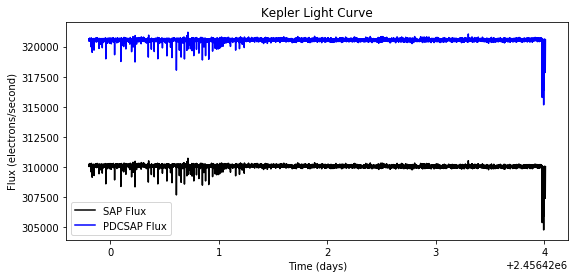

-----------------------------
disposition CONFIRMED


kepid                        9530945
kepoi_name                 K00708.02
kepler_name             Kepler-216 b
koi_disposition            CONFIRMED
koi_pdisposition           CANDIDATE
koi_score                          1
koi_fpflag_nt                      0
koi_fpflag_ss                      0
koi_fpflag_co                      0
koi_fpflag_ec                      0
koi_period                   7.69364
koi_period_err1            2.057e-05
koi_period_err2           -2.057e-05
koi_time0bk                  176.504
koi_time0bk_err1             0.00224
koi_time0bk_err2            -0.00224
koi_impact                     0.366
koi_impact_err1                0.142
koi_impact_err2               -0.366
koi_duration                  5.0324
koi_duration_err1             0.0656
koi_duration_err2            -0.0656
koi_depth                      295.1
koi_depth_err1                     6
koi_depth_err2                    -6
koi_prad                        2.12
koi_prad_err1                   0.36
k

,Unnamed: 0,bjdrefi,bjdreff,times,bjds,sap_fluxes,pdcsap_fluxes
0,0,2454833,0.0,782.268773,2.455615e+06,32575.516,37486.200
1,1,2454833,0.0,782.269454,2.455615e+06,32565.867,37474.960
2,2,2454833,0.0,782.270135,2.455615e+06,32547.494,37453.652
3,3,2454833,0.0,782.270817,2.455615e+06,32642.588,37563.344
4,4,2454833,0.0,782.271498,2.455615e+06,32578.191,37488.890
...,...,...,...,...,...,...,...
29485,29485,2454833,0.0,802.351861,2.455635e+06,32566.299,37469.344
29486,29486,2454833,0.0,802.352542,2.455635e+06,32557.686,37459.750
29487,29487,2454833,0.0,802.353223,2.455635e+06,32523.303,37420.418
29488,29488,2454833,0.0,802.353904,2.455635e+06,32562.781,37466.383


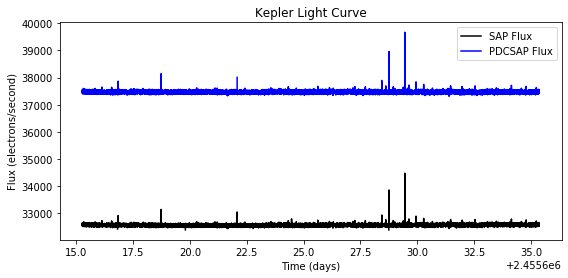

-----------------------------
disposition CONFIRMED


kepid                       11288051
kepoi_name                 K00241.02
kepler_name             Kepler-124 d
koi_disposition            CONFIRMED
koi_pdisposition           CANDIDATE
koi_score                      0.982
koi_fpflag_nt                      0
koi_fpflag_ss                      0
koi_fpflag_co                      0
koi_fpflag_ec                      0
koi_period                   30.9506
koi_period_err1            0.0002187
koi_period_err2           -0.0002187
koi_time0bk                  153.845
koi_time0bk_err1             0.00547
koi_time0bk_err2            -0.00547
koi_impact                     0.958
koi_impact_err1                0.015
koi_impact_err2               -0.665
koi_duration                   5.394
koi_duration_err1              0.208
koi_duration_err2             -0.208
koi_depth                      301.4
koi_depth_err1                  14.2
koi_depth_err2                 -14.2
koi_prad                        1.51
koi_prad_err1                   0.11
k

,Unnamed: 0,bjdrefi,bjdreff,times,bjds,sap_fluxes,pdcsap_fluxes
0,0,2454833,0.0,691.116307,2.455524e+06,NaN,NaN
1,1,2454833,0.0,691.116988,2.455524e+06,NaN,NaN
2,2,2454833,0.0,691.117669,2.455524e+06,NaN,NaN
3,3,2454833,0.0,691.118351,2.455524e+06,NaN,NaN
4,4,2454833,0.0,691.119032,2.455524e+06,NaN,NaN
...,...,...,...,...,...,...,...
41755,41755,2454833,0.0,719.555646,2.455553e+06,27626.625,30478.205
41756,41756,2454833,0.0,719.556327,2.455553e+06,27600.385,30449.299
41757,41757,2454833,0.0,719.557008,2.455553e+06,27640.652,30493.783
41758,41758,2454833,0.0,719.557689,2.455553e+06,27610.277,30460.322


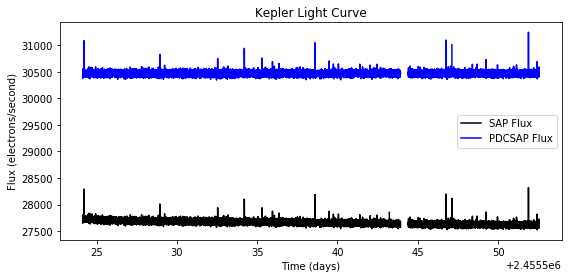

-----------------------------


In [64]:
for i in range(0, 3):
    get_random_plot_from_csv(df_koi_csv, True, "CONFIRMED")
    print("-----------------------------")

In [41]:
# Pinta un grafico de un elemento aleatorio de un kepid
def get_random_local_plot_from_csv(df_koi_csv, savePlot=False):
    rand_idx = rnd.choice(df_koi_csv.index)
    files = get_csv_from_koi(df_koi_csv["kepid"][rand_idx])
    # files = get_csv_from_koi(11231334)
    
    df_csv = pd.read_csv(files[-1])   

    df_csv.dropna()

    display(df_koi_csv.loc[rand_idx])
    display(df_csv)


    # obtenemos el bjd que tenga menor intensidad de luz    
    bjd_con_valor_minimo = df_csv["bjds"][df_csv['sap_fluxes'].idxmin()]

    # obtenemos un rango que vaya del valor minimo de flux +- el periodo del exoplaneta
    periodo_l = bjd_con_valor_minimo - df_koi_csv.loc[rand_idx, "koi_duration"] / 2 - df_koi_csv.loc[rand_idx, "koi_duration_err2"]
    periodo_r = bjd_con_valor_minimo + df_koi_csv.loc[rand_idx, "koi_duration"] / 2 + df_koi_csv.loc[rand_idx, "koi_duration_err1"]

    # TO-DO meter esto en una funcion
    # plot_light_curve(df_csv["bjds"], df_csv["sap_fluxes"], df_csv["pdcsap_fluxes"], savePlot, files[-1])
    plt.figure(figsize=(9,4))

    # Muestra el flujo de luz corregido y no corregido
    # plt.plot(df_csv["bjds"], np.log(df_csv["sap_fluxes"]), '-k', label='SAP Flux') 
    # plt.plot(df_csv["bjds"], np.log(df_csv["pdcsap_fluxes"]), '-b', label='PDCSAP Flux')

    plt.plot(df_csv["bjds"], df_csv["sap_fluxes"], '-k', label='SAP Flux') 
    plt.plot(df_csv["bjds"], df_csv["pdcsap_fluxes"], '-b', label='PDCSAP Flux') 

    plt.axvline(x=periodo_l, color="r") # raya vertical
    plt.axvline(x=bjd_con_valor_minimo, color="r") # raya vertical
    plt.axvline(x=periodo_r, color="r") # raya vertical


    plt.title('Kepler Light Curve')
    plt.legend()
    plt.xlabel('Time (days)')
    plt.ylabel('Flux (electrons/second)')
    
    plt.show()


for i in range(0, 4):
    get_random_local_plot_from_csv(df_koi_csv, True, "CONFIRMED")
    print("-----------------------------")

TypeError: get_random_local_plot_from_csv() takes from 1 to 2 positional arguments but 3 were given

In [37]:
# Version 1: unifica todos los CSV con TODOS los flux o solo con los determinados en col_slice
def get_unified_info_dataframe(df_koi_csv, replaceCsv=False, col_slice=None):
    fileFind = "./mastDownload/Bintables/*/*.csv"
    files = glob.glob(fileFind)

    df_unified = pd.DataFrame()
    i = 0
    for csv_file in files:
        # obtenemos el dataframe con las mediciones flux
        csv_df = pd.read_csv(csv_file)
        csv_df = csv_df.drop("Unnamed: 0", axis=1) # quitamos la columna unnamed
        csv_df = csv_df[csv_df['pdcsap_fluxes'].notna()] # quitamos las filas con pdcsap_fluxes nan

        # trasponemos, sacamos los fluxes y quitamos el indice
        pdcsap_fluxes = csv_df.T['pdcsap_fluxes':'pdcsap_fluxes'].reset_index(drop=True)
        # renombramos todas las columnas a flux_xxxxxxxxx
        pdcsap_fluxes.rename(columns=lambda x: "flux_" + str(format(pdcsap_fluxes.columns.get_loc(x) + 0,"09")), inplace=True)

        if col_slice != None:
            pdcsap_fluxes = pdcsap_fluxes.loc[:, :"flux_" + str(format(col_slice, "09"))]


        # obtenemos el kepid del fichero
        kepid = csv_file.split("\\")[-1].split("-")[0][4:]
        
        # buscamos la/s fila/s asociada/s a ese kepid
        row = df_koi_csv.loc[df_koi_csv['kepid'] == int(kepid)]
        row = row.loc[:, 'kepid':'koi_score'] # solo las columnas que nos interesan
        filled = pd.concat([row,pdcsap_fluxes],axis=1).ffill()
        filled = filled[filled['kepid'].notna()] # quitamos las filas con pdcsap_fluxes nan

        df_unified = df_unified.append(filled, ignore_index=True)

        """
        i = i+1
        if i == 4:
            break
        """

    # ponemos las columnas al principio
    mainColumns = ["kepid","kepoi_name","kepler_name","koi_disposition","koi_pdisposition","koi_score"]
    for col_name in reversed(mainColumns):
        col = df_unified.pop(col_name)
        df_unified.insert(0, col_name, col)

    # grabamos fichero
    if replaceCsv:
        unified_file_path = "./mast-info-unified.csv"
        if col_slice != None:
            unified_file_path = "./mast-info-unified-" + str(format(col_slice, "09")) + ".csv"

        df_unified.to_csv(unified_file_path)
    return df_unified

In [38]:
import sys

# Version 2: unifica todos los CSV con los flux locales
def get_unified_local_info_dataframe(df_koi_csv, replaceCsv=False, col_slice=None):
    fileFind = "./mastDownload/Bintables/*/*.csv"
    files = glob.glob(fileFind)

    print("peras")
    sys.exit("parar")

    df_unified = pd.DataFrame()
    i = 0
    for csv_file in files:
        # obtenemos el dataframe con las mediciones flux
        csv_df = pd.read_csv(csv_file)
        csv_df = csv_df.drop("Unnamed: 0", axis=1) # quitamos la columna unnamed
        csv_df = csv_df[csv_df['pdcsap_fluxes'].notna()] # quitamos las filas con pdcsap_fluxes nan

        # trasponemos, sacamos los fluxes y quitamos el indice
        pdcsap_fluxes = csv_df.T['pdcsap_fluxes':'pdcsap_fluxes'].reset_index(drop=True)
        # renombramos todas las columnas a flux_xxxxxxxxx
        pdcsap_fluxes.rename(columns=lambda x: "flux_" + str(format(pdcsap_fluxes.columns.get_loc(x) + 0,"09")), inplace=True)

        if col_slice != None:
            pdcsap_fluxes = pdcsap_fluxes.loc[:, :"flux_" + str(format(col_slice, "09"))]


        # obtenemos el kepid del fichero
        kepid = csv_file.split("\\")[-1].split("-")[0][4:]
        
        # buscamos la/s fila/s asociada/s a ese kepid
        row = df_koi_csv.loc[df_koi_csv['kepid'] == int(kepid)]
        row = row.loc[:, 'kepid':'koi_score'] # solo las columnas que nos interesan
        filled = pd.concat([row,pdcsap_fluxes],axis=1).ffill()
        filled = filled[filled['kepid'].notna()] # quitamos las filas con pdcsap_fluxes nan

        df_unified = df_unified.append(filled, ignore_index=True)

        """
        i = i+1
        if i == 4:
            break
        """

    # ponemos las columnas al principio
    mainColumns = ["kepid","kepoi_name","kepler_name","koi_disposition","koi_pdisposition","koi_score"]
    for col_name in reversed(mainColumns):
        col = df_unified.pop(col_name)
        df_unified.insert(0, col_name, col)

    # grabamos fichero
    if replaceCsv:
        unified_file_path = "./mast-info-unified.csv"
        if col_slice != None:
            unified_file_path = "./mast-info-unified-" + str(format(col_slice, "09")) + ".csv"

        df_unified.to_csv(unified_file_path)
    return df_unified

In [39]:
newProcess = True

if newProcess:
    df_unified = get_unified_local_info_dataframe(df_koi_csv, replaceCsv=False, col_slice=4000)
else:
    df_unified = pd.read_csv("./mast-info-unified-000004000.csv",engine='python')

df_unified = df_unified.drop("Unnamed: 0", axis=1)
display(df_unified[:15])

peras


SystemExit: parar